# 2_B: Energy Price Modeling (Random Forest & Co)

In this notebook, we use the energy price, generation, demand and demand forecast data in order to create energy price predictions.

Here we'll take a naive approach: We'll simply regress energy prices against a set of variables of interest, using four models:

- A linear regression
- A Ridge regression
- A Random Forest model
- An XGBoost model

Let's take the data we wrangled in the first notebook and see which model gives us the best results!

In [28]:
import shap
%matplotlib inline
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance

# Data Wrangling
import numpy as np
import pandas as pd
import datetime
pd.set_option('display.max_columns',50)

# Model Creation
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.metrics import r2_score

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

In [2]:
energy_df = pd.read_csv('./Modeling_DataFrames/price_gen_demand.csv')

In [3]:
energy_df.set_index('date_and_time', inplace=True)

In [4]:
energy_df

,load_zone,zone_price,wind_mwh,solar_mwh,biomass_mwh,carbon_mwh,combined_cycle_mwh,internal_combustion_mwh,geothermal_mwh,hydro_mwh,nuclear_mwh,conventional_thermal_mwh,natural_gas_mwh,NES_demand_mwh,NES_forecasted_demand_mwh,NES_MAPE
date_and_time,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,MONTERREY,469.72,2046.9551,0.014,24.1485,1236.4395,15212.2632,295.2078,602.0889,1639.9140,1481.9633,1612.2789,1323.9454,3724.0,3947,5.988185
2019-01-01 01:00:00,MONTERREY,468.52,2008.7178,0.014,24.5787,1259.8450,14716.7802,290.7521,600.6413,1359.4183,1482.0395,1622.8851,1316.4896,3677.0,3845,4.568942
2019-01-01 02:00:00,MONTERREY,460.61,2053.5246,0.000,23.2666,1264.3421,14158.9726,283.5448,601.0346,1109.2743,1482.5726,1631.1217,1318.2459,3625.0,3756,3.613793
2019-01-01 03:00:00,MONTERREY,460.76,2080.1841,0.000,24.9682,1264.9099,13554.0873,278.6723,603.3866,918.1252,1481.9557,1689.4191,1317.6234,3587.0,3707,3.345414
2019-01-01 04:00:00,MONTERREY,447.46,2183.7016,0.000,23.5932,1256.3677,12898.8769,274.7940,603.0097,922.1471,1482.7002,1654.2472,1315.9542,3522.0,3623,2.867689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,MONTERREY,450.59,1699.0485,0.000,24.2125,1880.1356,18286.1982,248.0208,496.1574,4794.6894,1565.9424,2131.5933,1328.9278,4545.0,4437,2.376238
2022-12-31 20:00:00,MONTERREY,421.95,1504.0209,0.000,24.2535,1880.4144,18130.0572,256.1454,496.4124,3831.8063,1566.4951,1963.7167,1311.5874,4344.0,4248,2.209945
2022-12-31 21:00:00,MONTERREY,410.96,1513.9210,0.000,23.2470,1844.1023,17786.4980,255.6818,496.4954,2769.6718,1566.3799,1958.3510,1300.0403,4225.0,4108,2.769231


The MAPE score and Load Zone information might be informative, but the former is more of a benchmark than a variable, and the latter doesn't really contribute anything to our modeling. Let's separate and store the former and strike the latter, making sure zone_price has a "MTY" tag in it so we know we're talking about the distributed node corresponding to the Monterrey load zone.

In [5]:
NES_forecast_and_MAPE = energy_df[['NES_forecasted_demand_mwh', 'NES_MAPE']]
energy_df.columns = ['load_zone', 'mty_zone_price', 'gen_wind_mwh', 'gen_solar_mwh', 'gen_biomass_mwh',
                     'gen_carbon_mwh', 'gen_combined_cycle_mwh', 'gen_internal_combustion_mwh', 
                     'gen_geothermal_mwh', 'gen_hydro_mwh', 'gen_nuclear_mwh', 'gen_conventional_thermal_mwh', 
                     'gen_natural_gas_mwh', 'NES_demand_mwh', 'NES_forecasted_demand_mwh', 'NES_MAPE']
energy_df.drop(columns=['load_zone', 'NES_forecasted_demand_mwh', 'NES_MAPE'], inplace=True)

In [6]:
NES_forecast_and_MAPE

,NES_forecasted_demand_mwh,NES_MAPE
date_and_time,,
2019-01-01 00:00:00,3947,5.988185
2019-01-01 01:00:00,3845,4.568942
2019-01-01 02:00:00,3756,3.613793
2019-01-01 03:00:00,3707,3.345414
2019-01-01 04:00:00,3623,2.867689
...,...,...
2022-12-31 19:00:00,4437,2.376238
2022-12-31 20:00:00,4248,2.209945
2022-12-31 21:00:00,4108,2.769231


In [7]:
energy_df.describe()

,mty_zone_price,gen_wind_mwh,gen_solar_mwh,gen_biomass_mwh,gen_carbon_mwh,gen_combined_cycle_mwh,gen_internal_combustion_mwh,gen_geothermal_mwh,gen_hydro_mwh,gen_nuclear_mwh,gen_conventional_thermal_mwh,gen_natural_gas_mwh,NES_demand_mwh
count,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000,35059.000000
mean,844.090500,2219.935882,1583.588208,10.904992,1625.485326,20989.020728,284.231610,514.284394,3478.635543,1248.145636,3048.511100,1781.297848,6467.122080
std,552.403396,969.666552,1943.528809,9.514819,729.402737,2731.066557,90.479443,54.789102,1902.664724,359.516099,1245.956226,396.142423,1252.805246
min,21.240000,0.000400,0.000000,0.000000,0.000000,674.687100,0.000000,240.198800,0.000000,0.000000,80.000000,0.000000,901.000000
25%,477.030000,1507.615650,0.000100,2.773800,1096.962650,19234.895900,211.250950,474.138100,1879.938800,779.253350,2083.565600,1479.668250,5516.000000
50%,696.590000,2183.154900,172.513000,4.066100,1515.320200,21180.472100,273.146300,510.897800,3165.731200,1422.571100,2777.924700,1731.072400,6283.000000
75%,1013.255000,2890.564350,3253.428350,20.669150,1995.522500,22920.095500,360.217100,557.763950,4812.861100,1536.119800,3706.002050,2030.892750,7437.000000
max,7035.530000,5389.233200,6483.817300,31.815500,4187.580500,27767.873300,525.291400,645.158000,9552.225500,1582.532300,7162.843400,3793.740900,10034.000000


In [8]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35059 entries, 2019-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   mty_zone_price                35059 non-null  float64
 1   gen_wind_mwh                  35059 non-null  float64
 2   gen_solar_mwh                 35059 non-null  float64
 3   gen_biomass_mwh               35059 non-null  float64
 4   gen_carbon_mwh                35059 non-null  float64
 5   gen_combined_cycle_mwh        35059 non-null  float64
 6   gen_internal_combustion_mwh   35059 non-null  float64
 7   gen_geothermal_mwh            35059 non-null  float64
 8   gen_hydro_mwh                 35059 non-null  float64
 9   gen_nuclear_mwh               35059 non-null  float64
 10  gen_conventional_thermal_mwh  35059 non-null  float64
 11  gen_natural_gas_mwh           35059 non-null  float64
 12  NES_demand_mwh                350

In [9]:
energy_df.corr()

,mty_zone_price,gen_wind_mwh,gen_solar_mwh,gen_biomass_mwh,gen_carbon_mwh,gen_combined_cycle_mwh,gen_internal_combustion_mwh,gen_geothermal_mwh,gen_hydro_mwh,gen_nuclear_mwh,gen_conventional_thermal_mwh,gen_natural_gas_mwh,NES_demand_mwh
mty_zone_price,1.000000,-0.079708,-0.050840,-0.043229,0.296539,0.164024,0.014507,0.110574,0.308935,-0.137232,0.369898,0.298836,0.399271
gen_wind_mwh,-0.079708,1.000000,-0.018574,0.101043,-0.161934,-0.162669,-0.165926,-0.105590,-0.056569,0.068263,-0.282505,-0.104773,-0.053871
gen_solar_mwh,-0.050840,-0.018574,1.000000,-0.070096,-0.116616,-0.066056,-0.232591,-0.163748,-0.044505,0.001897,-0.091233,0.018142,0.168815
gen_biomass_mwh,-0.043229,0.101043,-0.070096,1.000000,0.124365,-0.426984,-0.247261,0.358480,-0.335356,-0.083470,-0.136152,-0.314287,-0.384249
gen_carbon_mwh,0.296539,-0.161934,-0.116616,0.124365,1.000000,-0.038669,0.347200,0.624576,-0.153407,-0.041588,0.590656,0.196336,0.143776
gen_combined_cycle_mwh,0.164024,-0.162669,-0.066056,-0.426984,-0.038669,1.000000,0.165573,-0.264300,0.498204,0.017331,0.153258,0.476922,0.600509
gen_internal_combustion_mwh,0.014507,-0.165926,-0.232591,-0.247261,0.347200,0.165573,1.000000,0.265520,0.031109,0.005784,0.509302,0.277714,0.166770
gen_geothermal_mwh,0.110574,-0.105590,-0.163748,0.358480,0.624576,-0.264300,0.265520,1.000000,-0.294785,0.007229,0.370157,-0.068179,-0.112298
gen_hydro_mwh,0.308935,-0.056569,-0.044505,-0.335356,-0.153407,0.498204,0.031109,-0.294785,1.000000,-0.064935,0.124091,0.471427,0.472127
gen_nuclear_mwh,-0.137232,0.068263,0.001897,-0.083470,-0.041588,0.017331,0.005784,0.007229,-0.064935,1.000000,-0.110872,0.071881,0.027725


In [10]:
correlations = energy_df.corr(method='pearson')
print(correlations['mty_zone_price'].sort_values(ascending=False).to_string())

mty_zone_price                  1.000000
NES_demand_mwh                  0.399271
gen_conventional_thermal_mwh    0.369898
gen_hydro_mwh                   0.308935
gen_natural_gas_mwh             0.298836
gen_carbon_mwh                  0.296539
gen_combined_cycle_mwh          0.164024
gen_geothermal_mwh              0.110574
gen_internal_combustion_mwh     0.014507
gen_biomass_mwh                -0.043229
gen_solar_mwh                  -0.050840
gen_wind_mwh                   -0.079708
gen_nuclear_mwh                -0.137232


Naturally, the variable with the strongest correlation to energy prices is energy demand (real and forecasted) in the Northeast region of the country. After that, conventional thermal generation has a positive correlation with energy prices that's roughly as strong as energy demand's. What's interesting, however, is how solar, nuclear and wind generation are *negatively* correlated with energy prices. The more renewable and nuclear energy is put into the mix, the lower energy prices go. That seems like a win-win.

# ML Model Building

## Splitting Data

In [11]:
## Create target variable
target = 'mty_zone_price'

# Split data into feature matrix and target vector
y = energy_df[target]
X = energy_df.drop(columns=target)

# split data into train / validation sets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.2,random_state=42)

# Setting Baselines

In [12]:
# Assign variables for baselines and calculate baselines
y_pred = [y_train.mean()]*len(y_train)
mean_baseline_pred = y_train.mean()
baseline_mae = mean_absolute_error(y_train,y_pred)
baseline_rmse = mean_squared_error(y_train,y_pred,squared=False)

# Print statement to show all baseline values
print('Mean Price Per MWh Baseline Pred (MXN):', mean_baseline_pred)
print('-------------------------------------------------------------------')
print('Baseline MAE:',baseline_mae)
print('-------------------------------------------------------------------')
print('Baseline RMSE:',baseline_rmse)

Mean Price Per MWh Baseline Pred (MXN): 844.0102531464984
-------------------------------------------------------------------
Baseline MAE: 378.84283537124776
-------------------------------------------------------------------
Baseline RMSE: 556.4839771622425


In [13]:
# Assigning model variables
model_lr=LinearRegression()
model_r=Ridge()

# Fitting models
model_r.fit(X_train,y_train);
model_lr.fit(X_train,y_train);

# Def to check model metrics of baseline performance
def check_metrics(model):
    print(model)
    print('===================================================================')
    print('Training MAE:', mean_absolute_error(y_train,model.predict(X_train)))
    print('-------------------------------------------------------------------')
    print('Validation MAE:', mean_absolute_error(y_val,model.predict(X_val)))
    print('-------------------------------------------------------------------')
    print('Validation R2 score:', model.score(X_val,y_val))
    print('===================================================================')
model = [model_r,model_lr]
for m in model:
  check_metrics(m)

Ridge()
Training MAE: 283.0139377770437
-------------------------------------------------------------------
Validation MAE: 277.5741850070625
-------------------------------------------------------------------
Validation R2 score: 0.3689768618090923
LinearRegression()
Training MAE: 283.0139382283501
-------------------------------------------------------------------
Validation MAE: 277.57418569873454
-------------------------------------------------------------------
Validation R2 score: 0.36897686150055686


## Random Forest and XGBoost

In [14]:
# Assigning model variables
model_rfr = RandomForestRegressor()
model_xgbr=XGBRegressor()

# Fitting models
model_rfr.fit(X_train,y_train);
model_xgbr.fit(X_train,y_train);

# Def to check model metrics of baseline performance
def check_metrics(model):
    print(model)
    print('===================================================================')
    print('Training MAE:', mean_absolute_error(y_train,model.predict(X_train)))
    print('-------------------------------------------------------------------')
    print('Validation MAE:', mean_absolute_error(y_val,model.predict(X_val)))
    print('-------------------------------------------------------------------')
    print('Validation R2 score:', model.score(X_val,y_val))
    print('===================================================================')
model = [model_xgbr,model_rfr]
for m in model:
  check_metrics(m)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Training MAE: 116.96964827595173
-------------------------------------------------------------------
Validation MAE: 164.68379718839273
-------------------------------------------------------------------
Validation R2 score: 0.6981490680940999
RandomForestReg

It seems that of the four models attempted here, Random Forest Regressor outperforms the Linear Regression, Ridge, and XGBoost. Let's see if we can't push the Random Forest Regressor even further.

## Random Forest Regressor RandomSearch

In [15]:
# Pipeline variable for RandomSearch
pipe_rs_rfr = make_pipeline(RandomForestRegressor(random_state=42,
                                                  n_jobs=-1))

# Params for RandomSearch
pramajams = {'randomforestregressor__max_depth':range(5,35,5),
             'randomforestregressor__n_estimators':range(25,200,10),
             'randomforestregressor__max_samples':np.arange(0.2,1,0.1),
             'randomforestregressor__max_features':['sqrt','log2'],
             'randomforestregressor__min_samples_split':np.arange(2,5,1)}

# RandomSearch Model
model_rs_rfr = RandomizedSearchCV(pipe_rs_rfr,
                                  param_distributions=pramajams,
                                  n_iter=20,
                                  n_jobs=-1)

# Model fit
model_rs_rfr.fit(X_train,y_train);

# Check model metrics
print('Training MAE:', mean_absolute_error(y_train,model_rs_rfr.predict(X_train)))
print('-------------------------------------------------------------------')
print('Validation MAE:', mean_absolute_error(y_val,model_rs_rfr.predict(X_val)))
print('-------------------------------------------------------------------')
print('R2 score:', model_rs_rfr.score(X_val,y_val))
print('===================================================================')
model_rs_rfr.best_params_

Training MAE: 52.71092176228743
-------------------------------------------------------------------
Validation MAE: 125.66123336611626
-------------------------------------------------------------------
R2 score: 0.7679652836722897


{'randomforestregressor__n_estimators': 75,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__max_samples': 0.9000000000000001,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__max_depth': 30}

We only barely improved on the Random Forest Regressor model's R2 score (by about 0.004)

### Model Visualization

In [16]:
rfr_model_fin = RandomForestRegressor(n_estimators=155,
                                     min_samples_split=3,
                                     max_samples=0.9000000000000001,
                                     max_features='sqrt',
                                     max_depth=25)

In [17]:
rfr_model_fin.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, max_features='sqrt',
                      max_samples=0.9000000000000001, min_samples_split=3,
                      n_estimators=155)

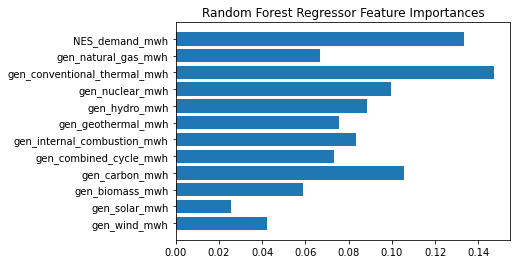

In [21]:
plt.barh(X_val.columns, rfr_model_fin.feature_importances_)
plt.title("Random Forest Regressor Feature Importances");

According to this feature importance chart, the variables with the most importance within this model are generation nmbers for conventional thermal, carbon, and overall energy demand in the Northeast.

In [26]:
price_pred = rfr_model_fin.predict(X_val)

## Model Scoring

In [29]:
r2_score(y_val, price_pred)

0.7703499820762801

In [30]:
(mean_squared_error(y_val, price_pred)) ** 0.5

256.7316447866667

According to this RMSE measure, when forecasting the price of energy, our RandomForestRegressor error is off boy about 256 MXN, give or take.